# The Human Connectome Hosts Connectivity Instrength Gradients

# Schaefer Connectome

This connectome was computed based on the Schaefer parcellation with 1000 regions (<a href='#Schaefer2018'>Schaefer et al., 2018</a>). First, tractograms were computed from the Human Connectome Project S900 release. Next, connection weights and lengths between regions defined by the Schaefer parcellation were calculated from the SIFT2 filterd streamlines for 776 subjects of the HCP data.

In [2]:
import os, sys
import numpy as np
import matplotlib.pylab as plt
import mne
import pickle
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr
from palettable.scientific.sequential import Davos_20, Turku_20, LaPaz_20_r

cmap_strength = Davos_20.mpl_colormap
cmap_weights = Turku_20.mpl_colormap

sys.path.append('../../modules/')
from visualization import *
from helpers import *

plt.rcParams['image.cmap'] = 'cividis'
dpi = 300
page_width = 2244  # pxl at 300 dpi

In [3]:
# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves_old/data/connectomes/Schaefer2018_HCP_S900"
regions_path = "/Users/dk/Documents/Charite/PhD/travelingwaves_code/data/connectomes/Schaefer2018_HCP_S900/hcp_parcellation"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/20_results"

In [4]:
# Load Mesh Geometry
# ------------------
# load schaefer surface mesh
with open(os.path.join(data_path, "schaefer_surface_mesh.pkl"), 'rb') as f:
    surface_mesh = pickle.load(f)
    
v_lh = surface_mesh['vertices_lh']
f_lh = surface_mesh['faces_lh']
v_rh = surface_mesh['vertices_rh']
f_rh = surface_mesh['faces_rh']
number_of_regions_per_hemi = v_lh.shape[0]
number_of_regions = number_of_regions_per_hemi * 2

# combine left and right hemispheres
v_lh[:,0] = v_lh[:,0] - (v_lh[:,0].max() - v_lh[:,0].min())

v = np.concatenate([v_lh, v_rh])
v[:,0] = v[:,0]
f = np.concatenate([f_lh, f_rh+number_of_regions_per_hemi])

### Aggregate connection weights and lengths

In [762]:
# load connectivity weights and lengths
weights = []
lengths = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith("connectome.csv"):
            df = pd.read_csv(os.path.join(root, file), header=None)
            weights.append(df.to_numpy())
        if file.endswith("lengths_sift2.csv"):
            df = pd.read_csv(os.path.join(root, file), header=None)
            lengths.append(df.to_numpy())

In [763]:
# remove background, medial wall, and other non-cortical regions
weights_cleaned = []
lengths_cleaned = []

for i, w in enumerate(weights):
    w = w[1:1002,1:1002]
    w = np.delete(w, 500, 0)
    w = np.delete(w, 500, 1)
    weights_cleaned.append(w)
    
for i, d in enumerate(lengths):
    d = d[1:1002,1:1002]
    d = np.delete(d, 500, 0)
    d = np.delete(d, 500, 1)
    lengths_cleaned.append(d)

In [764]:
# remove self-connections
weights_nsc = [w - np.eye(np.shape(w)[0])*np.diag(w) for w in weights_cleaned]
lengths_nsc = [l - np.eye(np.shape(l)[0])*np.diag(l) for l in lengths_cleaned]

# make symmetric
weights_nsc = [w + w.T - np.diag(np.diag(w)) for w in weights_nsc]
lengths_nsc = [l + l.T - np.diag(np.diag(l)) for l in lengths_nsc]

In [109]:
#np.save(os.path.join(data_path, 'weights_nsc.npy'), weights_nsc)
#np.save(os.path.join(data_path, 'lenghts_nsc.npy'), lengths_nsc)
#weights_nsc = np.load(os.path.join(data_path, 'weights_nsc.npy'))
#lengths_nsc = np.load(os.path.join(data_path, 'lengths_nsc.npy'))

In [8]:
number_of_subjects = len(weights_nsc)

### Consistency-thresholding of structural connectivity (<a href='#Roberts2017'>Roberts et al., 2017</a>)

In [163]:
p = 0.15

number_of_regions = 1000
number_of_possible_connections = number_of_regions**2
number_connections_preserved = int(np.round((number_of_possible_connections)*p/2))  # number of connections to preserve

Ws = np.array(weights_nsc).transpose(2,1,0)  # make weight matrix regions x regions x subjects
Wmean = np.mean(Ws,axis=2)  # compute mean weights
Wcv = np.true_divide(np.std(Ws, axis=2, ddof=1), Wmean, where = Wmean!=0)  # compute coefficient of variation

Wmean = np.triu(Wmean)  # get upper triangular matrix

ind = np.argwhere(Wmean)  # find indices of connections

Wcv_sorted = np.sort(Wcv[ind[:,0],ind[:,1]])  # sort connections based on coefficient of variation
Wmean[Wcv>Wcv_sorted[:number_connections_preserved][-1]] = 0  # remove connections with large CV

Ls = np.array(lengths_nsc).transpose(2,1,0)  # make weight matrix regions x regions x subjects
lengths_mean = np.triu(np.mean(Ls, axis=2))  # compute average_lengths
lengths_mean[Wcv>Wcv_sorted[:number_connections_preserved][-1]] = 0  # remove connections with large CV

avg_weights = Wmean + Wmean.T  # make matrix symmetric
avg_lengths = lengths_mean + lengths_mean.T

assert np.sum(avg_weights!=0) / number_of_possible_connections == p
assert np.all(avg_weights==avg_weights.T)

In [6]:
## save data
#np.save(os.path.join(data_path,'avg_weights.npy'), avg_weights)
#np.save(os.path.join(data_path,'avg_lengths.npy'), avg_lengths)

# load data
avg_weights = np.load(os.path.join(data_path,'avg_weights.npy'))
avg_lengths = np.load(os.path.join(data_path,'avg_lengths.npy'))

### Structural Connectivity Matrix

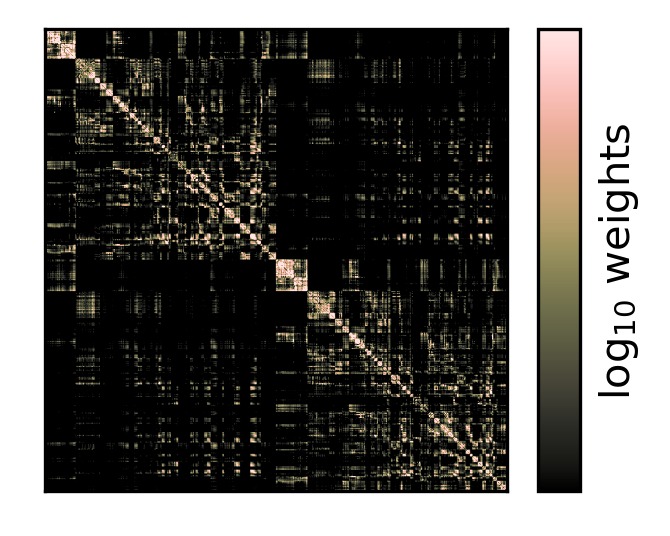

In [9]:
# Plot log10-weights
fig, ax = plt.subplots(1, figsize=(2, 2), dpi=300)

log_weights = np.zeros_like(avg_weights)
log_weights[avg_weights!=0] = np.log10(avg_weights[avg_weights!=0])

weights_threshold = np.percentile(log_weights[log_weights!=0].flatten(), 90)  # clip log10-weights at 90th percentile

im = ax.imshow(log_weights, cmap=cmap_weights, aspect=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([])

cbar_ax = fig.add_axes([0.95, 0.11, 0.07, 0.77])
cbar = fig.colorbar(im, ax=ax, cax=cbar_ax, pad=0.02)
cbar.set_label('log$_{10}$ weights')
cbar.set_ticks(ticks=[10.5, 71])
cbar.set_ticklabels(['low', 'high'])
cbar.ax.tick_params(size=0, rotation=90)
im.set_clim([0, weights_threshold])


#plt.savefig(os.path.join(figure_path, '20_structural_connectivity.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, '20_structural_connectivity.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Connection weight - length relationship

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


PearsonRResult(statistic=-0.4659961348587526, pvalue=0.0)


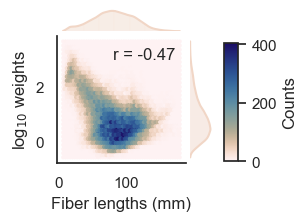

In [43]:
# Plot log10-weights -- fiber length relationship
sns.set_theme(style="white")

length_weights = pd.DataFrame(data=np.array([avg_lengths[(avg_lengths>0)&(avg_weights>0)], np.log10(avg_weights[(avg_lengths>0)&(avg_weights>0)])]).T, columns=['lengths', 'weights'])

j = sns.jointplot(length_weights, x='lengths', y='weights', kind='hex', height=2,
                  cmap=LaPaz_20_r.mpl_colormap, 
                  marginal_kws={'color': LaPaz_20_r.mpl_colormap(0.1), 'kde': True, 'fill': True})
j.ax_joint.set_ylabel('log$_{10}$ weights')
j.ax_joint.set_xlabel('Fiber lengths (mm)')
j.ax_joint.text(80, 3, "r = %.2f" % length_weights['lengths'].corr(length_weights['weights']))
j.ax_marg_x.set_axis_off()
j.ax_marg_y.set_axis_off()

cbar_ax = j.fig.add_axes([0.96, 0.12, .07, 0.59])  # x, y, width, height
plt.colorbar(cax=cbar_ax, label='Counts')

print(pearsonr(length_weights['lengths'], length_weights['weights']))

#plt.savefig(os.path.join(figure_path, 'schaefer1000_weights-lengths-distribution.png'), dpi=300, transparent=False, bbox_inches='tight')

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/seaborn/axisgrid.py:1760: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


PearsonRResult(statistic=0.7962300886535505, pvalue=0.0)


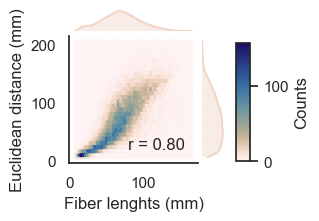

In [46]:
# fiber length - euclidean distance
from sklearn.metrics.pairwise import euclidean_distances
sns.set_theme(style="white")

# Compute euclidean
euclidean_distance_lh = np.triu(euclidean_distances(v_lh)) * 1e3  # convert m to mm
x_euclid = euclidean_distance_lh[(np.triu(avg_lengths[:500,:500])>0) & (np.triu(avg_weights[:500,:500])>0)]

# create dataframe
length_distance = pd.DataFrame(data=np.array([x_euclid, np.triu(avg_lengths[:500,:500])[np.triu(avg_lengths[:500,:500])>0]]).T, columns=['distance', 'lengths'])

# plot
j = sns.jointplot(length_distance, x='lengths', y='distance', kind='hex', height=2,
                  cmap=LaPaz_20_r.mpl_colormap, 
                  marginal_kws={'color': LaPaz_20_r.mpl_colormap(0.1), 'kde': True, 'fill': True})
j.ax_joint.set_xlabel('Fiber lenghts (mm)')
j.ax_joint.set_ylabel('Euclidean distance (mm)')
j.ax_joint.text(80, 20, "r = %.2f" % length_distance['lengths'].corr(length_distance['distance']))
j.ax_marg_x.set_axis_off()
j.ax_marg_y.set_axis_off()

cbar_ax = j.fig.add_axes([0.96, 0.12, .07, 0.59])  # x, y, width, height
plt.colorbar(cax=cbar_ax, label='Counts')

print(pearsonr(length_distance['lengths'], length_distance['distance']))

#plt.savefig(os.path.join(figure_path, 'schaefer1000_distance-lengths-distribution.png'), dpi=300, transparent=False, bbox_inches='tight')

### Instrength distribution

In [7]:
# Compute instrength
instrength = np.sum(avg_weights, axis=0)

#np.save(os.path.join(data_path, 'instrength.npy'), instrength)

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


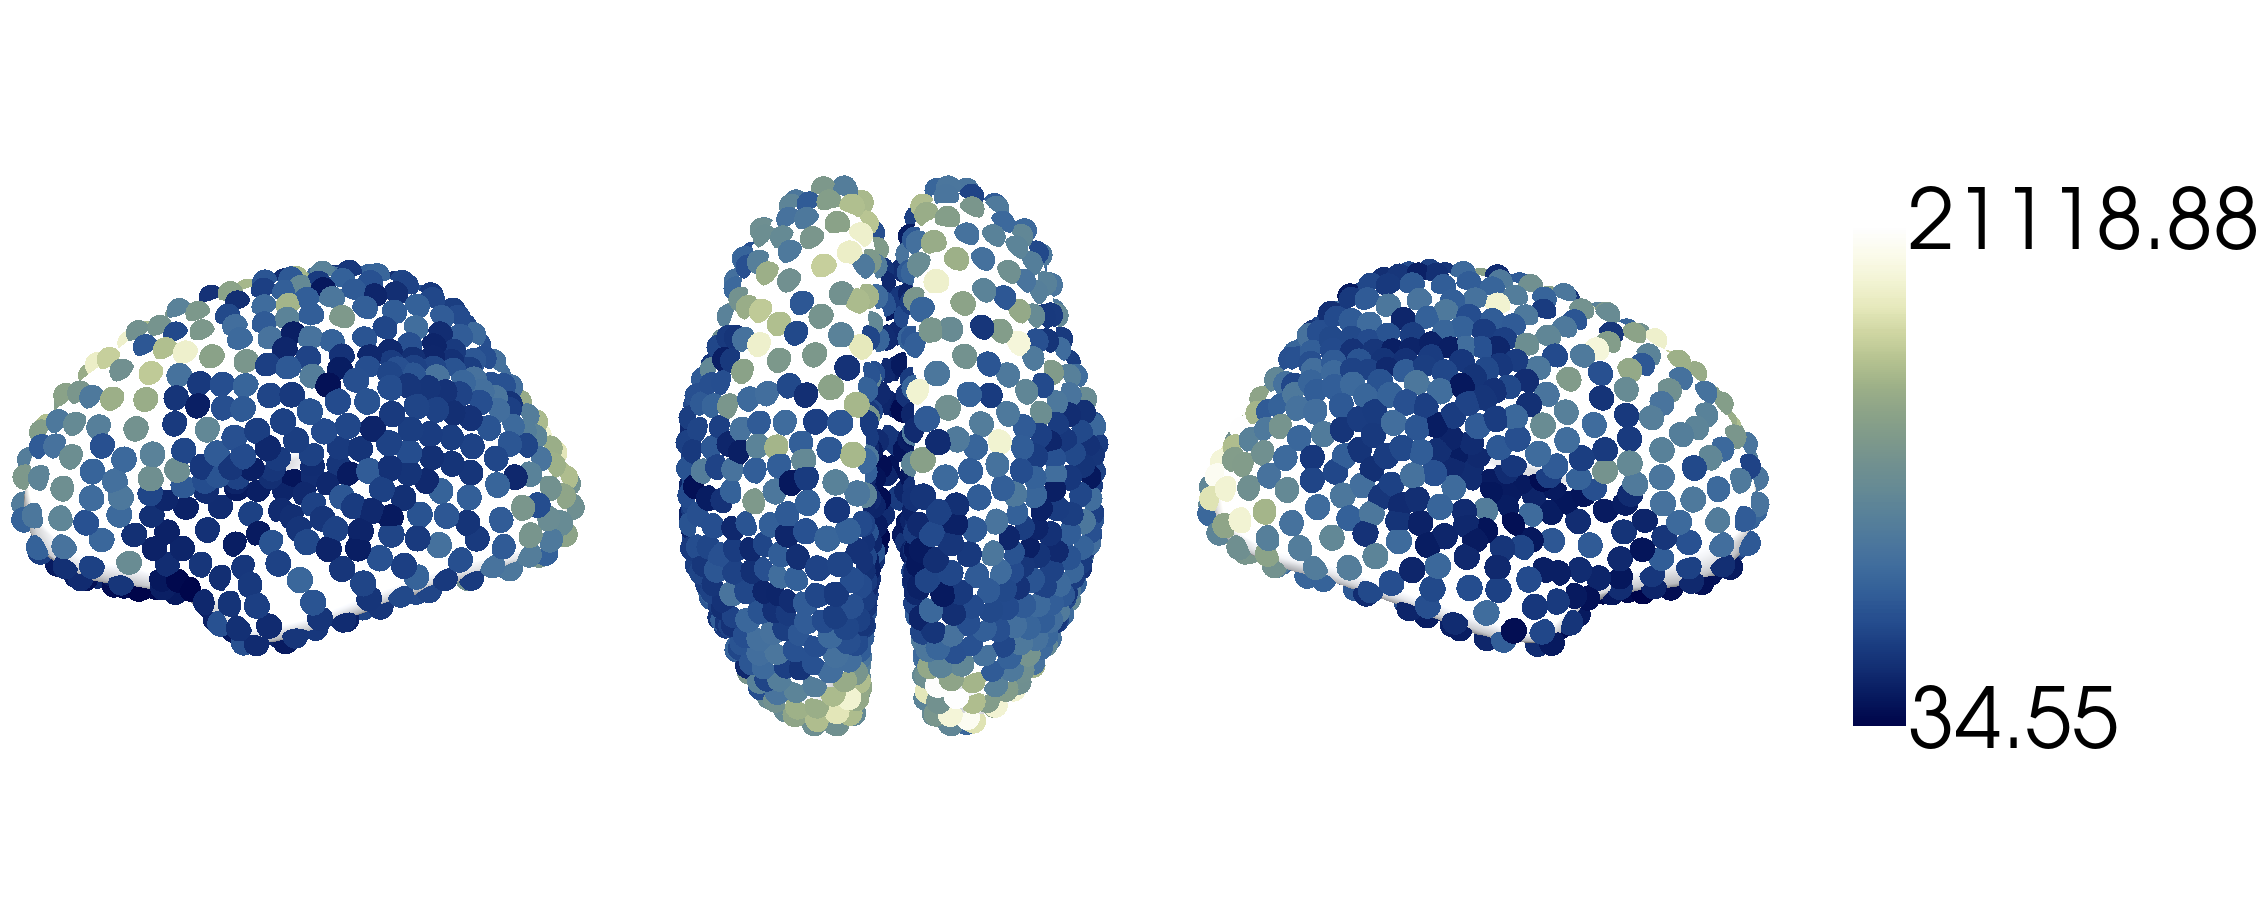

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/pyvista/core/filters/data_set.py:2290: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [1171]:
# Plot instrength on cortex
filename = os.path.join(figure_path, 'instrength.png')

plot_brain_data(v, f, instrength, cmap=cmap_strength)
plot_brain_data(v, f, instrength, filename=filename, cmap=cmap_strength)

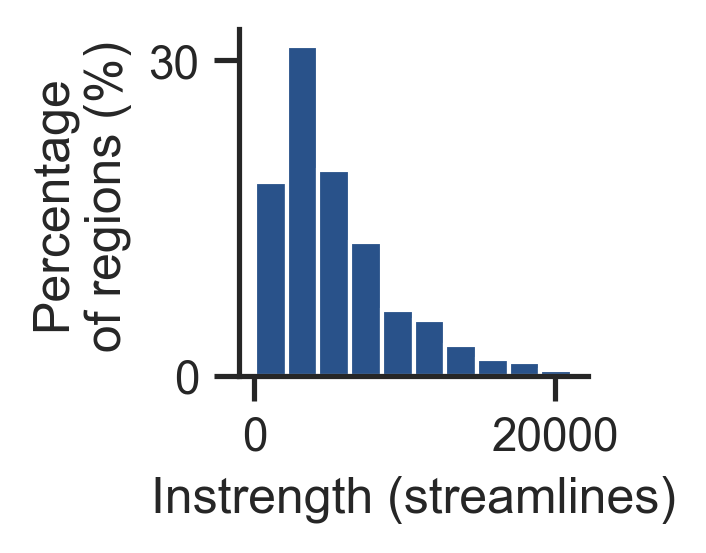

In [66]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(1, figsize=(1.5, 1.5), dpi=300)

ax.hist(instrength, color='#29528a', weights=np.ones(1000)*100/1000)
ax.set_xlabel('Instrength (streamlines)')
ax.set_ylabel('Percentage\n of regions (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 20000])
ax.set_yticks([0, 30])

plt.savefig(os.path.join(figure_path, 'instrength_histogram.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'instrength_histogram.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [79]:
# characterize distribution
instrength_median = np.median(instrength)
instrength_iqr = np.percentile(instrength, [25, 75])

print(f'median: {instrength_median:.2f} ({instrength_iqr[0]:.2f} - {instrength_iqr[1]:.2f})')
print('skewness: %.2f' % sp.stats.skew(instrength))
sp.stats.skewtest(instrength)

median: 4273.78 (2559.73 - 7314.13)
skewness: 1.33


SkewtestResult(statistic=13.477127458234321, pvalue=2.1324880591085172e-41)

### Instrength spectro-spatial modal analysis

To identify the presence of gradients in our data, we compute the eigenspectrum and statistically show that certain spatial frequencies dominate.

In [1]:
# Configure stats
n_permutations = 10000
significance_level = 0.01

In [16]:
# Compute eigenmodes of mesh
k = 100
l, e, m = spectral_decomposition(v_lh, f_lh, k)

# compute spatial frequencies from eigenvalues
# Vallet and Lévy (2007; 'Spectral Geometry Processing with Manifold Harmonics') and 
# Iivanainen et al. (2021; 'Spatial sampling of MEG and EEG based on generalized spatial-frequency analysis and optimal design')
spatial_frequencies = np.sqrt(l[1:])/(2*np.pi)  # exclude first eigenvalue because the component relates to zero frequency

assert np.all(np.isclose(e.T @ m @ e, np.identity(k)))  # check orthonormality

#### Group-level spectral analysis

In [17]:
# project instrength onto eigenbasis
instrength_lh = instrength[:number_of_regions_per_hemi]

# project instrength onto harmonics through massmatrix: see section 2.2 and 3.1 in Vallet and Lévy (2007; 'Spectral Geometry Processing with Manifold Harmonics') 
spectrum = instrength_lh.dot(m.dot(e[:,1:]))  

# conduct permutation tests
spectrum_perm = np.zeros((n_permutations, k-1))
for i in range(n_permutations):
    spectrum_perm[i] = instrength_lh[np.random.permutation(range(number_of_regions_per_hemi))].dot(m.dot(e[:,1:]))

# normalize by original spectrum
power_avg = spectrum**2 / np.sum(spectrum**2)
power_avg_perm = spectrum_perm**2 / np.sum(spectrum**2)

# p value calculation
p_values = np.sum(power_avg_perm >= power_avg, axis=0) / n_permutations
p_values_corrected = p_values*len(p_values)  # bonferroni

significance_mask = p_values_corrected <= significance_level

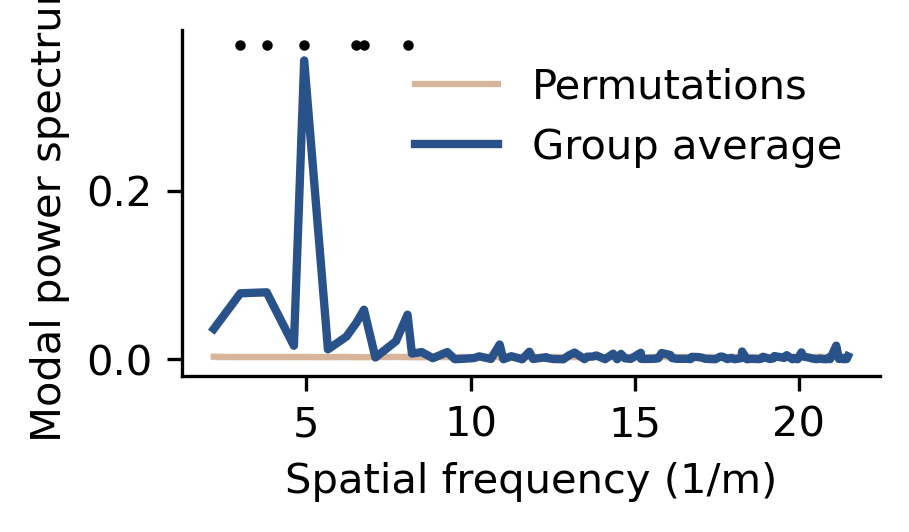

In [21]:
# Plot spatio-spectral modes spectrum
fig, ax = plt.subplots(1, figsize=(3, 1.5), dpi=300)

power_avg_perm_sd = np.std(power_avg_perm, axis=0)
power_avg_perm_mean = np.mean(power_avg_perm, axis=0)

ax.fill_between(spatial_frequencies, power_avg_perm_mean-power_avg_perm_sd, power_avg_perm_mean+power_avg_perm_sd, color='#d6b59b', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_avg_perm_mean, '#d6b59b', label = 'Permutations')
ax.plot(spatial_frequencies, power_avg, linewidth=2, color='#29528a', label='Group average')
ax.plot(spatial_frequencies[significance_mask], np.ones(sum(significance_mask))*ax.get_ylim()[1], 'k.', markersize=3)
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', useOffset=False)
plt.legend(frameon=False)

#plt.savefig(os.path.join(figure_path, 'spectrum_group.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, 'spectrum_group.svg'), dpi=300, transparent=False, bbox_inches='tight')

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


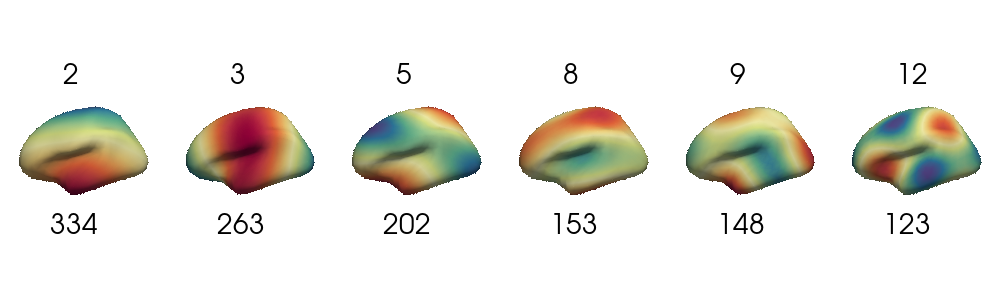

In [22]:
### Plot significant modes ###
pv.set_plot_theme('document')

significant_modes = np.where(significance_mask)[0]

# Build pyvista mesh
mesh_lh = pv.PolyData(v_lh)

# convert faces to pyvista
mesh_lh.faces = np.insert(f_lh.flatten(), np.arange(0,len(f_lh.flatten()),3), 3)

p = pv.Plotter(shape=(1,len(significant_modes)), off_screen=True, notebook=True, border=False, window_size=[1000,300])

for i, sm in enumerate(significant_modes):
    p.subplot(0,i)
    mesh_lh.point_data['data'] = e[:,sm+1]
    
    p.add_mesh(mesh_lh, point_size=0, show_scalar_bar=False, smooth_shading=True, cmap='spectral', copy_mesh=True)
    p.add_text(str(sm+1), font='arial', font_size=14, position=(63,210))
    p.add_text(str(int(1/spatial_frequencies[sm]*1000)), position=(50,60), font='arial', font_size=14)
    
    p.camera_position = 'zy'
    p.camera.azimuth = 0
    p.camera.elevation = 0
    p.camera.roll = 90
    p.camera.zoom(1.)

p.show()
#p.screenshot(os.path.join(figure_path, f'significant_modes.png'), transparent_background=True)
p.close()

#### Subject-level spectral analysis

In [23]:
# get instrengths per subject
instrength_sub = np.sum(weights_nsc, axis=-1)

In [24]:
# Compute spatio-spectral mode power
power = []
significant_modes = []
for sub in range(number_of_subjects):
    print(f"\rSubject {sub}", end="")
    
    # project instrength onto eigenbasis
    instrength_lh = instrength_sub[sub,:number_of_regions_per_hemi]
    power_original = (instrength_lh.dot(m.dot(e[:,1:])))**2    
    
    # permutation testing
    power_perm = np.zeros((n_permutations, 99))
    for i in range(n_permutations):
        power_perm[i] = instrength_lh[np.random.permutation(range(number_of_regions_per_hemi))].dot(m.dot(e[:,1:]))**2

    # normalize by original spectrum
    power.append(power_original / np.sum(power_original))
    power_perm = power_perm / np.sum(power_original)

    # p value calculation
    p_values = np.sum(power_perm >= power[sub], axis=0)/n_permutations
    p_values_corrected = p_values*len(p_values)  # bonferroni
    significance_mask = p_values <= significance_level
    
    significant_modes.append(np.where(significance_mask)[0])  # get significant modes
    
power = np.array(power)

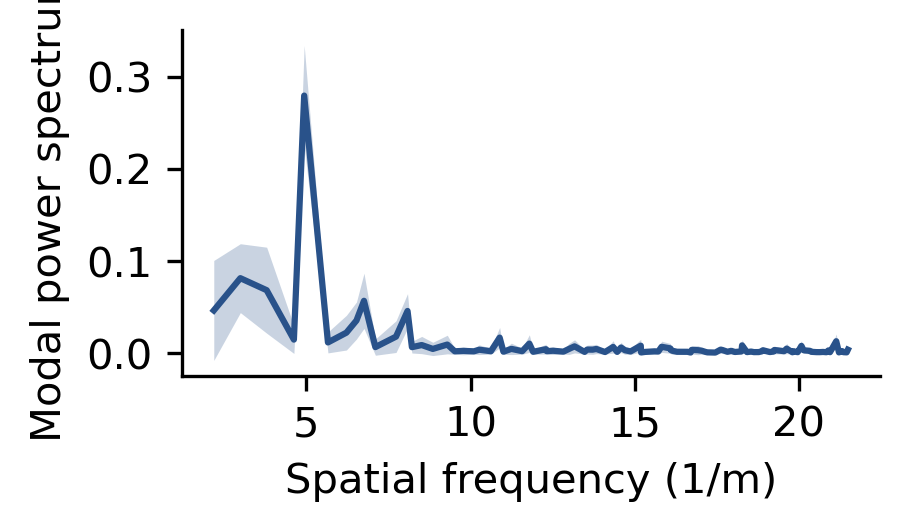

In [25]:
# Plot mean and SD modal power across subjects
fig, ax = plt.subplots(1, figsize=(3, 1.5), dpi=300)

power_perm_sd = np.std(power, axis=0)
power_perm_mean = np.mean(power, axis=0)

ax.fill_between(spatial_frequencies, power_perm_mean-power_perm_sd, power_perm_mean+power_perm_sd, color='#29528a', alpha=0.25, linewidth=0)
ax.plot(spatial_frequencies, power_perm_mean, '#29528a')
ax.set_xlabel('Spatial frequency (1/m)')
ax.set_ylabel('Modal power spectrum')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig(os.path.join(figure_path, 'spectrum_subjects.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, 'spectrum_subjects.svg'), dpi=300, transparent=False, bbox_inches='tight')

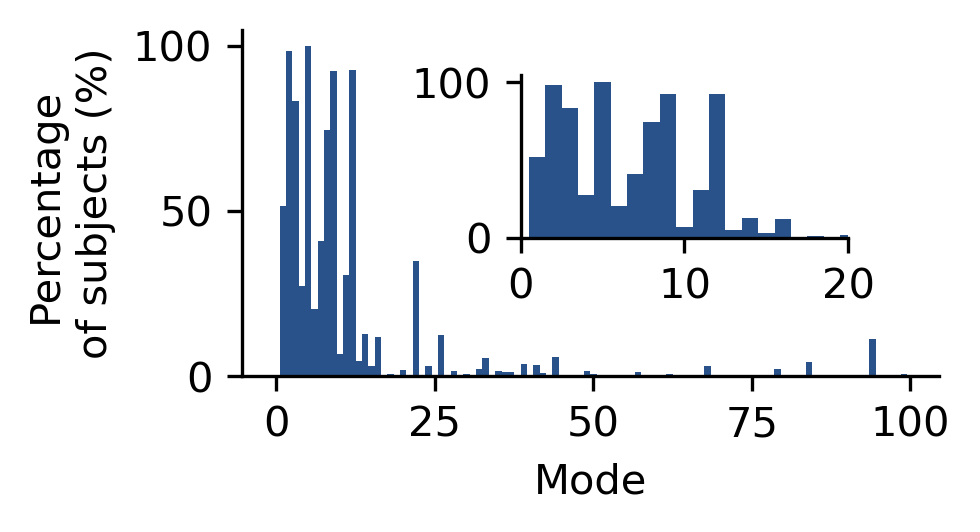

In [26]:
# Plot percentage of subjects with significant mode
def flatten(l):
    return [item for sublist in l for item in sublist]

fig, ax = plt.subplots(1, figsize=(3, 1.5), dpi=300)

ax.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes), linewidth=0.25)
ax.set_xlabel('Mode')
ax.set_ylabel('Percentage \nof subjects (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 50, 100])
axins = ax.inset_axes([0.4, 0.4, 0.47, 0.47])
axins.hist(np.array(flatten(significant_modes))+1, color='#29528a', bins=np.arange(-0.5, 100.5), weights=100*np.ones(len(flatten(significant_modes))) / len(significant_modes))
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.set_xlim([0,20])
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution.png'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, 'sig_mode_distribution.svg'), dpi=300, transparent=False, bbox_inches='tight')

# References
<a id='Schaefer2018'></a>Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114.

<a id='Roberts2017'></a>Roberts, J. A., Perry, A., Roberts, G., Mitchell, P. B., & Breakspear, M. (2017). Consistency-based thresholding of the human connectome. NeuroImage, 145, 118-129.